<a href="https://colab.research.google.com/github/Sanaz-salari/Pneumonia_Detection_ChestXray_SVM/blob/main/Pneumonia_Detection_ChestXray_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import necessary libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn import model_selection
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

**Configrations**

In [ ]:
# provide the path to the image data
GOOGLE_DRIVE_PATH = "/content/drive/MyDrive/Colab Notebooks"
INPUT_DATA_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'chest_xray')

# image configurations
LABELS = ['NORMAL', 'PNEUMONIA']
IMAGE_SIZE = 128
IMAGE_CHANNEL = 1

# model configuration
MODEL_NAME = 'ChestXRay_SVM_Model'
SVM_KERNELS = ('linear', 'poly', 'rbf')
REG_PARAMS = (0.1, 1, 10, 100)
TRAINING_RATIO = 0.6
VALIDATION_RATIO = 0.2
VERBOSE_MODE = True

**Function: Read images from files into arrays**

In [ ]:
def ReadImagesIntoDF(image_dir):
  data = []
  labels = []
  for label in LABELS: 
    path = os.path.join(image_dir, label)
    image_label = LABELS.index(label)
    for imagefile in os.listdir(path):
      try:
        image = cv2.imread(os.path.join(path, imagefile), cv2.IMREAD_GRAYSCALE)
        resized_image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        data.append(resized_image.flatten())
        labels.append(image_label)
      except Exception as e:
        print(e)
  data_DF = pd.DataFrame(np.array(data))
  data_DF['label'] = np.array(labels)
  return data_DF

**Construct training, validation and test sets**

In [ ]:
TrainingSet_DF = ReadImagesIntoDF(os.path.join(INPUT_DATA_PATH, 'train'))
ValidationSet_DF = ReadImagesIntoDF(os.path.join(INPUT_DATA_PATH, 'val'))
TestSet_DF = ReadImagesIntoDF(os.path.join(INPUT_DATA_PATH, 'test'))

**Analyzing the training and validation set**

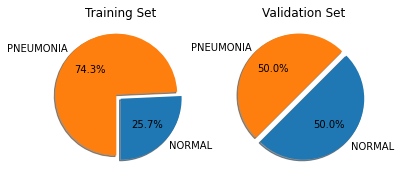

In [ ]:
trainingset_normal_counts = TrainingSet_DF[TrainingSet_DF['label'] == 0].shape[0]
trainingset_pneumonia_counts = TrainingSet_DF[TrainingSet_DF['label'] == 1].shape[0]
# plot
figure, axis = plt.subplots(1,2)
size = [trainingset_normal_counts, trainingset_pneumonia_counts]
explode = (0, 0.1)
axis[0].pie(size, explode=explode, labels=LABELS, autopct='%1.1f%%', shadow=True, startangle=270)
axis[0].set_title("Training Set")
validationset_normal_counts = ValidationSet_DF[ValidationSet_DF['label'] == 0].shape[0]
validationset_pneumonia_counts = ValidationSet_DF[ValidationSet_DF['label'] == 1].shape[0]
size = [validationset_normal_counts, validationset_pneumonia_counts]
explode = (0, 0.1)
axis[1].pie(size, explode=explode, labels=LABELS, autopct='%1.1f%%', shadow=True, startangle=225)
axis[1].set_title("Validation Set")
plt.show()

In [ ]:
print(TrainingSet_DF[TrainingSet_DF['label'] == 0].shape)
print(TrainingSet_DF[TrainingSet_DF['label'] == 1].shape)
print(ValidationSet_DF[ValidationSet_DF['label'] == 0].shape)
print(ValidationSet_DF[ValidationSet_DF['label'] == 1].shape)
print(TestSet_DF[TestSet_DF['label'] == 0].shape)
print(TestSet_DF[TestSet_DF['label'] == 1].shape)

(1341, 16385)
(3875, 16385)
(8, 16385)
(8, 16385)
(234, 16385)
(390, 16385)


**Balance and finalize the traing, validation, test combination**

In [ ]:
# Balance the labels in the training dataset
TrainingSet_LABEL0_DF = TrainingSet_DF[TrainingSet_DF['label'] == 0]
TrainingSet_LABEL1_DF = TrainingSet_DF[TrainingSet_DF['label'] == 1]

# Append the Validation set
TrainingValidationSet_LABEL0_DF = TrainingSet_LABEL0_DF.append(ValidationSet_DF[ValidationSet_DF['label'] == 0])
TrainingValidationSet_LABEL1_DF = TrainingSet_LABEL1_DF.append(ValidationSet_DF[ValidationSet_DF['label'] == 1])

# Append the Test set
TrainingValidationTestSet_LABEL0_DF = TrainingValidationSet_LABEL0_DF.append(TestSet_DF[TestSet_DF['label'] == 0])
TrainingValidationTestSet_LABEL1_DF = TrainingValidationSet_LABEL1_DF.append(TestSet_DF[TestSet_DF['label'] == 1])

# Balance the data set
TrainingValidationTestSet_LABEL1_DF = TrainingValidationTestSet_LABEL1_DF.iloc[:TrainingValidationTestSet_LABEL0_DF.shape[0],:]

# Split the dataset into training, validation and test datasets based on TRAINING_RATIO and VALIDATION_RATIO
training_index_label0 = int(TRAINING_RATIO*TrainingValidationTestSet_LABEL0_DF.shape[0])
training_index_label1 = int(TRAINING_RATIO*TrainingValidationTestSet_LABEL1_DF.shape[0])
validation_index_label0 = int((TRAINING_RATIO+VALIDATION_RATIO)*TrainingValidationTestSet_LABEL0_DF.shape[0])
validation_index_label1 = int((TRAINING_RATIO+VALIDATION_RATIO)*TrainingValidationTestSet_LABEL1_DF.shape[0])

xTraining = TrainingValidationTestSet_LABEL0_DF.iloc[:training_index_label0,:-1]
xTraining = xTraining.append(TrainingValidationTestSet_LABEL1_DF.iloc[:training_index_label1,:-1])
yTraining = TrainingValidationTestSet_LABEL0_DF.iloc[:training_index_label0,-1]
yTraining = yTraining.append(TrainingValidationTestSet_LABEL1_DF.iloc[:training_index_label1,-1])

xValidation = TrainingValidationTestSet_LABEL0_DF.iloc[training_index_label0:validation_index_label0,:-1]
xValidation = xValidation.append(TrainingValidationTestSet_LABEL1_DF.iloc[training_index_label1:validation_index_label1,:-1])
yValidation = TrainingValidationTestSet_LABEL0_DF.iloc[training_index_label0:validation_index_label0,-1]
yValidation = yValidation.append(TrainingValidationTestSet_LABEL1_DF.iloc[training_index_label1:validation_index_label1,-1])

xTest = TrainingValidationTestSet_LABEL0_DF.iloc[validation_index_label0:,:-1]
xTest = xTest.append(TrainingValidationTestSet_LABEL1_DF.iloc[validation_index_label1:,:-1])
yTest = TrainingValidationTestSet_LABEL0_DF.iloc[validation_index_label0:,-1]
yTest = yTest.append(TrainingValidationTestSet_LABEL1_DF.iloc[validation_index_label1:,-1])

print(xTraining.shape)
print(xValidation.shape)
print(xTest.shape)

(1898, 16384)
(634, 16384)
(634, 16384)


**Scale the image data set**

In [ ]:
xTraining = xTraining / 255
xValidation = xValidation / 255
xTest = xTest / 255
xValidation.describe()

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
count,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,...,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000
mean,0.205839,0.221828,0.225707,0.233909,0.248086,0.269741,0.272766,0.281202,0.284988,0.292837,...,0.245321,0.208258,0.170557,0.137416,0.110274,0.089237,0.073044,0.065417,0.062628,0.064316
std,0.216149,0.218675,0.206228,0.203066,0.206332,0.217418,0.206167,0.204351,0.198490,0.195490,...,0.220609,0.210140,0.192796,0.171364,0.152840,0.139162,0.121898,0.118019,0.118733,0.125532
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031373,0.047059,0.062745,0.078431,0.090196,0.109804,0.121569,0.137255,0.150000,0.160784,...,0.050980,0.024510,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.152941,0.172549,0.188235,0.196078,0.223529,0.239216,0.252941,0.258824,0.262745,0.270588,...,0.180392,0.131373,0.090196,0.074510,0.054902,0.035294,0.025490,0.007843,0.000000,0.000000
75%,0.293137,0.304902,0.313725,0.325490,0.348039,0.364706,0.368627,0.372549,0.388235,0.396078,...,0.442157,0.392157,0.292157,0.200000,0.152941,0.113725,0.098039,0.090196,0.090196,0.086275
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.996078,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
print(xTraining.shape)
print(np.count_nonzero(yTraining))

print(xValidation.shape)
print(np.count_nonzero(yValidation))

print(xTest.shape)
print(np.count_nonzero(yTest))

(1898, 16384)
949
(634, 16384)
317
(634, 16384)
317


**Fit and predict with SVM model**

In [ ]:
for k in SVM_KERNELS:
  for c in REG_PARAMS:
    # Fit the model
    model = svm.SVC(kernel=k, C=c)
    model.fit(xTraining, yTraining)

    # Make prediction
    yhatValidation = model.predict(xValidation)

    # calculate and print Confusion matrix, Precision, Recall, F1-Score
    cm = confusion_matrix(yValidation, yhatValidation)
    precision = precision_score(yValidation, yhatValidation)
    recall = recall_score(yValidation, yhatValidation)
    f1 = f1_score(yValidation, yhatValidation)
    print(f"Kernel = {k}, C = {c}:")
    print(f"    Confusion Matrix: {cm[0,:]}")
    print(f"                      {cm[1,:]}")
    print(f"    Precision: {precision}")
    print(f"    Recall: {recall}")
    print(f"    F1-Score: {f1}")

Kernel = linear, C = 0.1:
    Confusion Matrix: [298  19]
                      [ 10 307]
    Precision: 0.941717791411043
    Recall: 0.9684542586750788
    F1-Score: 0.9548989113530327
Kernel = linear, C = 1:
    Confusion Matrix: [298  19]
                      [ 10 307]
    Precision: 0.941717791411043
    Recall: 0.9684542586750788
    F1-Score: 0.9548989113530327
Kernel = linear, C = 10:
    Confusion Matrix: [298  19]
                      [ 10 307]
    Precision: 0.941717791411043
    Recall: 0.9684542586750788
    F1-Score: 0.9548989113530327
Kernel = linear, C = 100:
    Confusion Matrix: [298  19]
                      [ 10 307]
    Precision: 0.941717791411043
    Recall: 0.9684542586750788
    F1-Score: 0.9548989113530327
Kernel = poly, C = 0.1:
    Confusion Matrix: [303  14]
                      [ 14 303]
    Precision: 0.9558359621451105
    Recall: 0.9558359621451105
    F1-Score: 0.9558359621451105
Kernel = poly, C = 1:
    Confusion Matrix: [300  17]
               

**Predict the test data set and analyze the result**

Kernel = rbf, C = 10:
    Precision: 0.7103448275862069
    Recall: 0.9747634069400631
    F1-Score: 0.8218085106382979


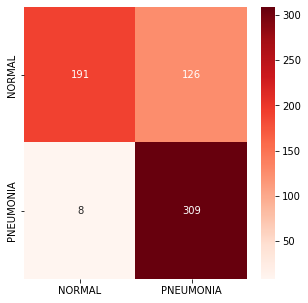

In [ ]:
k = "rbf"
c = 10

# Fit the model
model = svm.SVC(kernel=k, C=c)
model.fit(xTraining, yTraining)

# Make prediction
yhatTest = model.predict(xTest)

# Report Precision, Recall, F1-Score
precision = precision_score(yTest, yhatTest)
recall = recall_score(yTest, yhatTest)
f1 = f1_score(yTest, yhatTest)
print(f"Kernel = {k}, C = {c}:")
print(f"    Precision: {precision}")
print(f"    Recall: {recall}")
print(f"    F1-Score: {f1}")

# Confusion matrix
cm = confusion_matrix(yTest, yhatTest)
cm_DF = pd.DataFrame(cm , index=['0','1'] , columns=['0','1'])
plt.figure(figsize=(5, 5))
sns.heatmap(cm_DF, cmap="Reds", annot=True, fmt='', xticklabels=LABELS, yticklabels=LABELS)